In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense, Dropout,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
train_classes_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_classes_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

40479


In [6]:
train_classes_df.shape

(40479, 2)

In [7]:
sample_submission_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [8]:
test1 = !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l
test2 = !ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l
assert sample_submission_df.shape[0] == float(test1[0])+float(test2[0])

In [9]:
test2

['20522']

In [10]:
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train_classes = train_classes_df.copy()
train_classes['tags'].apply(append_labels)
unique_labels = list(unique_labels)
print(unique_labels)

['conventional_mine', 'habitation', 'blow_down', 'agriculture', 'primary', 'blooming', 'slash_burn', 'cultivation', 'partly_cloudy', 'road', 'clear', 'bare_ground', 'cloudy', 'artisinal_mine', 'haze', 'selective_logging', 'water']


In [11]:
len(unique_labels)

17

In [12]:
# let's do one hot encoding (vectorize) the labels in 'train_classes'
for tag in unique_labels:
    train_classes[tag] = train_classes['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
train_classes['image_name'] = train_classes['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_classes.head()

,image_name,tags,conventional_mine,habitation,blow_down,agriculture,primary,blooming,slash_burn,cultivation,partly_cloudy,road,clear,bare_ground,cloudy,artisinal_mine,haze,selective_logging,water
0,train_0.jpg,haze primary,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
2,train_2.jpg,clear primary,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0


In [13]:
# y_col = list(train_classes.columns[2:]) # storing the tags column names as a variable

# # initializing an image generator with some data augumentation
# image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# # loading images from dataframe
# gen = image_gen.flow_from_dataframe(dataframe=train_classes, \
#         directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
#        target_size=(64, 64), class_mode='raw', seed=1, batch_size=64)

In [14]:
# x=np.concatenate([gen.next()[0] for i in range(gen.__len__())])
# x

In [15]:
img_width = 64
img_height=64

X = []

for i in tqdm(range(train_classes_df.shape[0])):
    path = '../input/planets-dataset/planet/planet/train-jpg/'+train_classes_df["image_name"][i] + ".jpg"
    img = image.load_img(path,target_size=(img_width,img_height))
    img= image.img_to_array(img)
    img = img / 255
    
    X.append(img)
    
X = np.array(X)

100%|██████████| 40479/40479 [02:47<00:00, 241.71it/s]


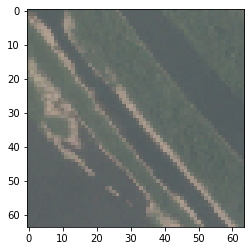

In [16]:
plt.imshow(X[20])

In [17]:
y = train_classes.drop(["image_name","tags"],axis=1)

y = y.to_numpy()
y.shape


(40479, 17)

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.2)

In [19]:
def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [20]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32),\
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [21]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(16,(3,3),activation="relu",input_shape=X_train[0].shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv2D(32,(3,3),activation="relu",input_shape=X_train[0].shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,(3,3),activation="relu",input_shape=X_train[0].shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128,(3,3),activation="relu",input_shape=X_train[0].shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.5))
    
    model.add(Flatten())

    model.add(Dense(128,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(17,activation="sigmoid"))
    
    model.summary()
    
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy",multi_label_acc, fbeta])
    
    return model


In [22]:
model = build_model()

ValueError: Negative dimension size caused by subtracting 3 from 2 for '{{node conv2d_4/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](dropout_3/cond/Identity, conv2d_4/Conv2D/ReadVariableOp)' with input shapes: [?,2,2,64], [3,3,64,128].

In [ ]:
print(y_train.shape,X_train.shape)

In [ ]:
history = model.fit(X_train,y_train,epochs=6,validation_data=(X_test,y_test))

In [ ]:
def plot_learning_curve(history,epoch):
    epoch_range = range(1,epoch+1)
    plt.plot(epoch_range,history.history["val_fbeta"])
    plt.plot(epoch_range,history.history["val_multi_label_acc"])
    plt.title("Value Fbeta")
    plt.ylabel("Val Multi label accuracy")
    plt.xlabel("Epoch")    
    plt.legend(["Train","Val"],loc="upper left")
    plt.show()
    
    plt.plot(epoch_range,history.history["loss"])
    plt.plot(epoch_range,history.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")    
    plt.legend(["Train","Val"],loc="upper left")
    plt.show()
    
    
    

In [ ]:
plot_learning_curve(history,6)

In [ ]:
import gc
del X_train, y_train,X_test,y_test,X #you can add other unnecessary data
gc.collect()

In [ ]:
#testing model
print(test1,test2)

img_width = 64
img_height=64

test_X = []
test_file = []

for i in tqdm(range(int(test1[0]))):
    path = '../input/planets-dataset/planet/planet/test-jpg/test_{}.jpg'.format(i)
    img = image.load_img(path,target_size=(img_width,img_height))
    img= image.img_to_array(img)
    img = img / 255
    
    test_X.append(img)
    test_file.append("test_{}".format(i))
    
for i in tqdm(range(int(test2[0]))):
    path = '../input/planets-dataset/test-jpg-additional/test-jpg-additional/file_{}.jpg'.format(i)
    img = image.load_img(path,target_size=(img_width,img_height))
    img= image.img_to_array(img)
    img = img / 255
    
    test_X.append(img)
    test_file.append("file_{}".format(i))
    
test_X = np.array(test_X)

In [ ]:
plt.imshow(test_X[10])

In [ ]:
y_prob = model.predict(test_X)

In [ ]:
test_pred = pd.DataFrame(y_prob)
test_pred

In [ ]:
test_pred =test_pred.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

In [ ]:
test_pred.shape

In [ ]:
import gc
del test_X 
gc.collect()

In [ ]:
test_df = pd.DataFrame({
    "image_name":test_file,
    "tags":test_pred
})

In [ ]:
test_df.head()

In [ ]:
#save the prdeiction dataframe dropping the index
test_df.to_csv("submission.csv",index=False)